Code to build and save various hidden weight initializations.

In [21]:
import numpy as np
import matplotlib.pyplot as plt
import os
import json

## Utility

In [22]:
def plot_weight_heatmap(W, title="W", symmetric=True):
    """Heatmap + colorbar with optional symmetric limits."""
    vlim = np.max(np.abs(W)) if symmetric else None
    plt.figure(figsize=(5, 4))
    plt.imshow(
        W,
        aspect="auto",
        origin="upper",
        vmin=(-vlim if symmetric else None),
        vmax=(vlim if symmetric else None),
    )
    plt.colorbar()
    plt.title(title)
    plt.xlabel("Columns (j)")
    plt.ylabel("Rows (i)")
    plt.tight_layout()
    plt.show()

In [23]:
def plot_weight_hist(W, bins=60, title="W values"):
    """Value distribution."""
    plt.figure(figsize=(5, 3))
    plt.hist(W.ravel(), bins=bins)
    plt.title(title)
    plt.tight_layout()
    plt.show()

In [24]:
def plot_eigenspectrum(W, title="eig(W)"):
    """Eigenvalues in the complex plane + spectral radius."""
    eig = np.linalg.eigvals(W)
    radius = np.max(np.abs(eig))
    plt.figure(figsize=(4, 4))
    plt.scatter(eig.real, eig.imag, s=10)
    circle = plt.Circle((0, 0), radius, fill=False, linestyle="--")
    ax = plt.gca()
    ax.add_artist(circle)
    ax.axhline(0, lw=0.5, color="k")
    ax.axvline(0, lw=0.5, color="k")
    ax.set_aspect("equal", "box")
    plt.title(f"{title} | spectral radius ≈ {radius:.3f}")
    plt.tight_layout()
    plt.show()

In [25]:
import numpy as np
import matplotlib.pyplot as plt


def plot_weight_all(W, title="Weights", symmetric=True, bins=60):
    """Plot heatmap, histogram, and eigenspectrum in one figure (3 rows, 1 col)."""
    eig = np.linalg.eigvals(W)

    fig, axes = plt.subplots(1, 3, figsize=(14, 4))

    # --- Heatmap ---
    vlim = np.max(np.abs(W)) if symmetric else None
    im = axes[0].imshow(
        W,
        aspect="auto",
        origin="upper",
        vmin=(-vlim if symmetric else None),
        vmax=(vlim if symmetric else None),
    )
    fig.colorbar(im, ax=axes[0], fraction=0.046, pad=0.04)
    axes[0].set_title(f"{title} Heatmap")

    # --- Histogram ---
    axes[1].hist(W.ravel(), bins=bins)
    axes[1].set_title(f"{title} Histogram")

    # --- Eigenspectrum ---
    radius = np.max(np.abs(eig))
    axes[2].scatter(eig.real, eig.imag, s=10)
    circle = plt.Circle((0, 0), radius, fill=False, linestyle="--")
    axes[2].add_artist(circle)
    axes[2].axhline(0, lw=0.5, color="k")
    axes[2].axvline(0, lw=0.5, color="k")
    axes[2].set_aspect("equal", "box")
    axes[2].set_title(f"{title} eigvals | spectral radius ≈ {radius:.3f}")

    plt.tight_layout()
    plt.show()

In [26]:
def xavier_variance(fan_in, fan_out, gain=1.0):
    # Xavier/Glorot normal: std = gain * sqrt(2 / (fan_in + fan_out))
    # → variance = gain^2 * 2 / (fan_in + fan_out)
    return (gain**2) * 2.0 / (fan_in + fan_out)

In [27]:
def save_matrix(W, save_dir, name, meta=None):
    """
    Saves W as .npy and optional metadata as .json (same basename).
    """
    os.makedirs(save_dir, exist_ok=True)
    base = os.path.join(save_dir, name)
    np.save(base + ".npy", W)
    if meta is not None:
        with open(base + ".json", "w") as f:
            json.dump(meta, f, indent=2)
    print(f"Saved: {base}.npy" + (" and .json" if meta is not None else ""))

## Weight matrices

### He and Xavier

In [28]:
def build_he(
    n_in, n_out, nonlinearity="relu", mode="fan_in", dist="normal", a=0.0, seed=None
):
    """
    He/Kaiming initialization.
    - nonlinearity: 'relu' or 'leaky_relu' (set a to negative_slope for leaky)
    - mode: 'fan_in' (forward activations) or 'fan_out' (backward gradients)
    - dist: 'normal' or 'uniform'
    - a: negative_slope for leaky ReLU (0.0 for ReLU)
    """
    rng = np.random.default_rng(seed)
    fan_in = n_in
    fan_out = n_out
    fan = fan_in if mode == "fan_in" else fan_out

    # gain per He/Kaiming
    if nonlinearity == "leaky_relu":
        gain = np.sqrt(2.0 / (1.0 + a**2))
    else:  # relu
        gain = np.sqrt(2.0)

    std = gain / np.sqrt(fan)

    if dist == "uniform":
        bound = np.sqrt(3.0) * std  # matches kaiming_uniform
        W = rng.uniform(-bound, bound, size=(n_out, n_in))
    else:
        W = rng.normal(0.0, std, size=(n_out, n_in))

    return W

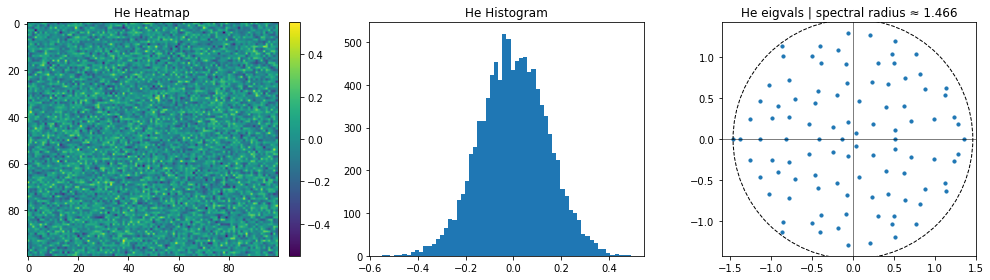

In [29]:
n = 100
W_he = build_he(
    n_in=n, n_out=n, nonlinearity="relu", mode="fan_in", dist="normal", seed=0
)
plot_weight_all(W_he, title="He")

In [30]:
def build_xavier(n_in, n_out, gain=1.0, seed=None):
    """Xavier/Glorot normal."""
    rng = np.random.default_rng(seed)
    std = gain * np.sqrt(2.0 / (n_in + n_out))
    W = rng.normal(0.0, std, size=(n_out, n_in))
    mean = W.mean()
    var = ((W - mean) ** 2).mean()
    return W, mean, var

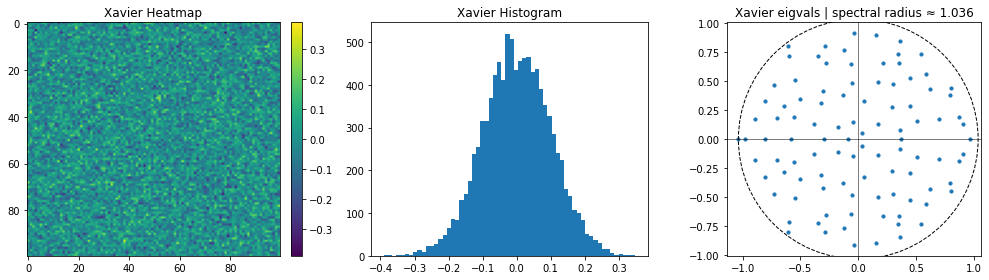

Xavier variance: : 0.009962


In [31]:
n = 100
W_xavier, mean_xavier, var_xavier = build_xavier(n_in=n, n_out=n, seed=0)
plot_weight_all(W_xavier, title="Xavier")
print(f"Xavier variance: : {var_xavier:.6f}")

### Shift matrix

In [32]:
def build_shift(n, off=1.0, target_var=None, cyclic=False, verbose=None):
    """Upper shift (superdiagonal = off)."""
    print("Building shift matrix")
    W = np.zeros((n, n), dtype=np.float32)
    idx = np.arange(n - 1)
    W[idx, idx + 1] = off
    if cyclic:
        W[-1, 0] = off

    # calculate empirical mean and variance
    var_emp = float(((W - W.mean()) ** 2).mean())
    if verbose:
        print(f"Variance prior to scaling: {var_emp:.6f}")

    # scale to xavier variance
    if target_var is not None and var_emp > 0:
        scale = np.sqrt(target_var / var_emp)
        W = (W * scale).astype(np.float32)
        var_scaled = float(((W - W.mean()) ** 2).mean())
        if verbose:
            print(f"Variance after scaling: {var_scaled:.6f}")

    return W

Building shift matrix
Variance prior to scaling: 0.009802
Variance after scaling: 0.010000


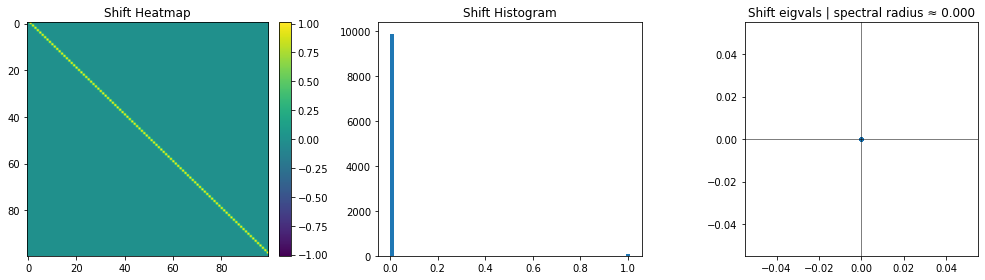

Saved: ../data/Ns100_SeqN100/hidden-weight-inits/hidden_shift_n100_xavier.npy and .json


In [33]:
n = 100
target_var = xavier_variance(n, n, gain=1)
W_shift = build_shift(n, off=1.0, target_var=target_var, cyclic=False, verbose=True)
plot_weight_all(W_shift, title="Shift")

save_matrix(
    W_shift,
    save_dir="../data/Ns100_SeqN100/hidden-weight-inits",
    name=f"hidden_shift_n{n}_xavier",
    meta={
        "type": "shift",
        "n": n,
        "target_var": target_var,
        "note": "scaled to Xavier variance. Not cyclic.",
    },
)

Building shift matrix
Variance prior to scaling: 0.009900
Variance after scaling: 0.010000


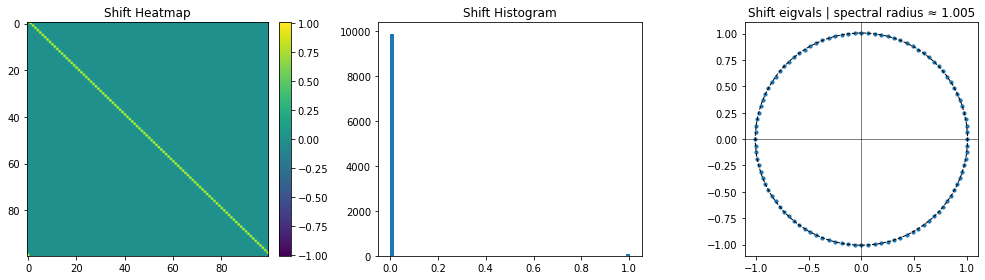

Saved: ../data/Ns100_SeqN100/hidden-weight-inits/hidden_cyclic_shift_n100_xavier.npy and .json


In [34]:
n = 100
target_var = xavier_variance(n, n, gain=1)
W_shift = build_shift(n, off=1.0, target_var=target_var, cyclic=True, verbose=True)
plot_weight_all(W_shift, title="Shift")

save_matrix(
    W_shift,
    save_dir="../data/Ns100_SeqN100/hidden-weight-inits",
    name=f"hidden_cyclic_shift_n{n}_xavier",
    meta={
        "type": "cyclic_shift",
        "n": n,
        "target_var": target_var,
        "note": "scaled to Xavier variance. Not cyclic.",
    },
)

### Mexican hat

In [ ]:
def build_mexican_hat(n, sigma=None, target_var=None, cyclic=False, verbose=False):
    """
    Build 1D Mexican-hat Toeplitz weight matrix (n x n).
    """
    if sigma is None:
        sigma = n / 10

    if verbose:
        print(
            f"Building Mexican-hat matrix (n={n}, sigma={sigma:.3f}, cyclic={cyclic})"
        )

    if cyclic:
        # distances on a ring: 0..n-1 mapped to min(d, n-d)
        d_vals = np.arange(n, dtype=np.int64)
        d_vals = np.minimum(d_vals, n - d_vals).astype(np.float64)
        k = (1.0 - (d_vals**2) / (sigma**2)) * np.exp(
            -(d_vals**2) / (2.0 * sigma**2)
        )

        # pairwise circular distances for all (i,j)
        idx = np.arange(n)
        d = np.abs(idx[:, None] - idx[None, :])
        d = np.minimum(d, n - d)  # circular distance
        W = k[d]  # broadcasted indexing builds the (n x n) matrix
    else:
        # straight-line offsets centered so main diagonal uses d=0
        center = n // 2
        x = np.arange(-center, n - center, dtype=np.float64)  # length n
        k = (1.0 - (x**2) / (sigma**2)) * np.exp(-(x**2) / (2.0 * sigma**2))

        # Toeplitz via (i - j) offset indexing; zero out-of-bounds
        i = np.arange(n)[:, None]
        j = np.arange(n)[None, :]
        off = (i - j) + center  # map offsets to [0, n-1]
        mask = (off >= 0) & (off < n)

        W = np.zeros((n, n))
        # Flattened masked assignment to avoid Python loops
        W[mask] = k[off[mask]]

    # ---- Variance reporting and optional rescaling ----
    var_emp = float(((W - W.mean()) ** 2).mean())
    if verbose:
        print(f"Variance prior to scaling: {var_emp:.6f}")

    if target_var is not None and var_emp > 0.0:
        scale = np.sqrt(target_var / var_emp, dtype=np.float64)
        W = W * scale
        var_scaled = float(((W - W.mean()) ** 2).mean())
        if verbose:
            print(f"Variance after scaling:  {var_scaled:.6f}")

    return W

Building Mexican-hat matrix (n=100, sigma=10.000, cyclic=True)
Variance prior to scaling: 0.132934
Variance after scaling:  0.010000


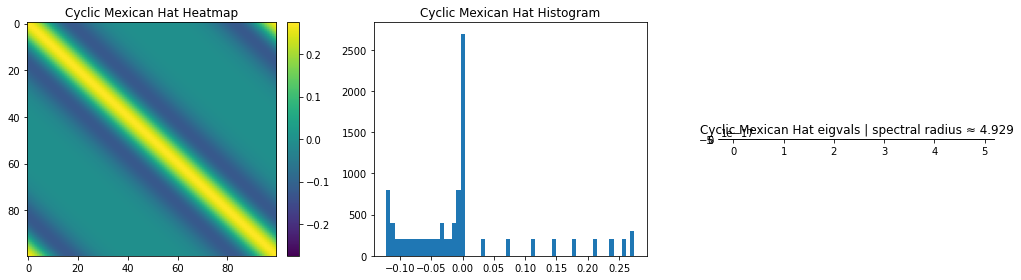

Saved: ../data/Ns100_SeqN100/hidden-weight-inits/hidden_cmh_n100_xavier.npy and .json


In [49]:
n = 100
target_var = xavier_variance(n, n, gain=1)
W_mh = build_mexican_hat(
    n=n, sigma=None, target_var=target_var, cyclic=True, verbose=True
)
plot_weight_all(W_mh, title="Cyclic Mexican Hat")

save_matrix(
    W_shift,
    save_dir="../data/Ns100_SeqN100/hidden-weight-inits",
    name=f"hidden_cmh_n{n}_xavier",
    meta={
        "type": "cyclic mexican hat",
        "n": n,
        "target_var": target_var,
        "note": "cyclic mexican hat scaled to xavier variance.",
    },
)

Building Mexican-hat matrix (n=100, sigma=10.000, cyclic=False)
Variance prior to scaling: 0.122550
Variance after scaling:  0.010000


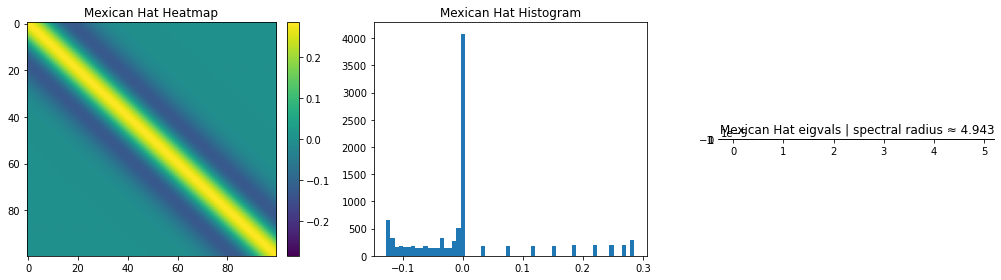

Saved: ../data/Ns100_SeqN100/hidden-weight-inits/hidden_mh_n100_xavier.npy and .json


In [50]:
n = 100
target_var = xavier_variance(n, n, gain=1)
W_mh = build_mexican_hat(
    n=n, sigma=None, target_var=target_var, cyclic=False, verbose=True
)
plot_weight_all(W_mh, title="Mexican Hat")

save_matrix(
    W_shift,
    save_dir="../data/Ns100_SeqN100/hidden-weight-inits",
    name=f"hidden_mh_n{n}_xavier",
    meta={
        "type": "mexican hat",
        "n": n,
        "target_var": target_var,
        "note": "mexican hat scaled to xavier variance. not cyclic.",
    },
)

### Tridiagonal

In [ ]:
def build_tridiag(n, diag=1.0, off=-1.0, cyclic=False, target_var=None, verbose=False):
    """(Cyclic) tridiagonal with diag and off-diagonals."""
    W = np.zeros((n, n))
    i = np.arange(n)
    W[i, i] = diag
    W[i[1:], i[:-1]] = off  # sub
    W[i[:-1], i[1:]] = off  # super
    if cyclic:
        W[0, -1] = off
        W[-1, 0] = off

    # empirical variance
    var_emp = float(((W - W.mean()) ** 2).mean())
    if verbose:
        print(f"Variance prior to scaling: {var_emp:.6f}")

    # optional variance scaling
    if (target_var is not None) and (var_emp > 0.0):
        scale = np.sqrt(target_var / var_emp)
        W = W * scale
        var_scaled = float(((W - W.mean()) ** 2).mean())
        if verbose:
            print(f"Variance after scaling:  {var_scaled:.6f}")

    return W

Variance prior to scaling: 0.029900
Variance after scaling:  0.010000


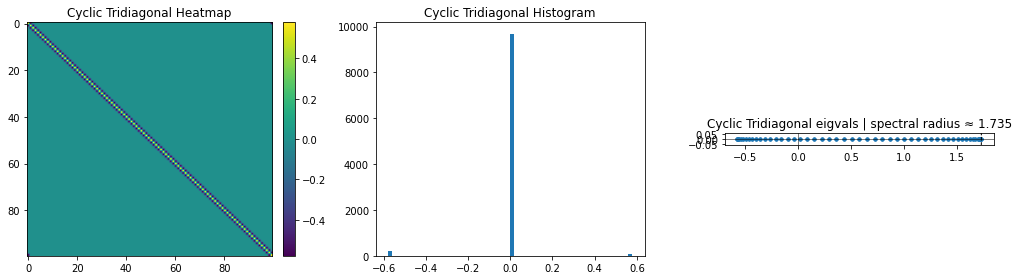

Saved: ../data/Ns100_SeqN100/hidden-weight-inits/hidden_ctridiag_n100_xavier.npy and .json


In [53]:
n = 100
target_var = xavier_variance(n, n, gain=1)
W_tridiag = build_tridiag(n, off=-1.0, cyclic=True, target_var=target_var, verbose=True)
plot_weight_all(W_tridiag, title="Cyclic Tridiagonal")

save_matrix(
    W_shift,
    save_dir="../data/Ns100_SeqN100/hidden-weight-inits",
    name=f"hidden_ctridiag_n{n}_xavier",
    meta={
        "type": "cyclic tridiagonal",
        "n": n,
        "target_var": target_var,
        "note": "cyclic tridiagonal scaled to xavier variance.",
    },
)

Variance prior to scaling: 0.029704
Variance after scaling:  0.010000


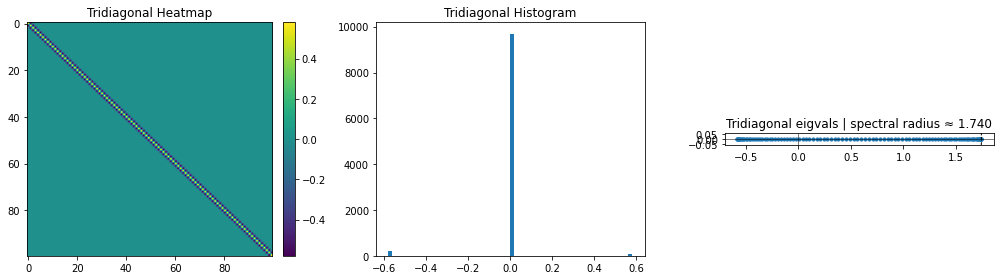

Saved: ../data/Ns100_SeqN100/hidden-weight-inits/hidden_tridiag_n100_xavier.npy and .json


In [ ]:
n = 100
target_var = xavier_variance(n, n, gain=1)
W_tridiag = build_tridiag(
    n, off=-1.0, cyclic=False, target_var=target_var, verbose=True
)
plot_weight_all(W_tridiag, title="Tridiagonal")

save_matrix(
    W_shift,
    save_dir="../data/Ns100_SeqN100/hidden-weight-inits",
    name=f"hidden_tridiag_n{n}_xavier",
    meta={
        "type": "tridiagonal",
        "n": n,
        "target_var": target_var,
        "note": "tridiagonal scaled to xavier variance.",
    },
)

### Orthogonal

In [ ]:
def build_orthogonal(
    n, scale=1.0, seed=None, target_var=None, verbose=False, ensure_det_pos=False
):
    if verbose:
        print(
            f"Building orthogonal matrix (n={n}, scale={scale}, target_var={target_var})"
        )

    rng = np.random.default_rng(seed)

    # Work in float64 for better orthogonality, cast at the end
    A = rng.normal(size=(n, n), loc=0.0, scale=1.0).astype(np.float64)

    # QR gives orthonormal columns in Q (A = Q R)
    Q, R = np.linalg.qr(A, mode="reduced")

    # Fix sign ambiguity so diag(R) is positive
    d = np.sign(np.diag(R))
    d[d == 0] = 1.0
    Q = Q * d  # broadcast over columns

    if ensure_det_pos and np.linalg.det(Q) < 0:
        # flip one column to make determinant positive
        Q[:, 0] *= -1.0

    # Apply initial scale
    W = scale * Q

    # Empirical variance (over entries of W)
    var_emp = float(((W - W.mean()) ** 2).mean())
    if verbose:
        print(f"Variance prior to scaling: {var_emp:.6f}")

    # Optional variance matching
    if target_var is not None and var_emp > 0.0:
        s = np.sqrt(target_var / var_emp, dtype=np.float64)
        W = W * s
        var_scaled = float(((W - W.mean()) ** 2).mean())
        if verbose:
            print(f"Variance after scaling:  {var_scaled:.6f}")

    return W

Building orthogonal matrix (n=100, scale=1.0, target_var=0.01)
Variance prior to scaling: 0.010000
Variance after scaling:  0.010000


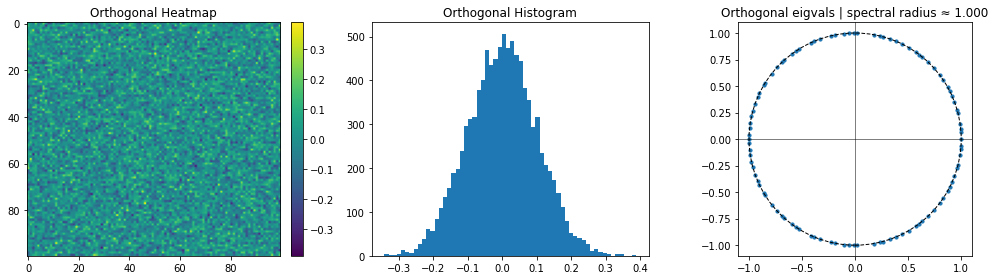

Saved: ../data/Ns100_SeqN100/hidden-weight-inits/hidden_orthog_n100_xavier.npy and .json


In [58]:
n = 100
target_var = xavier_variance(n, n, gain=1)
W_orth = build_orthogonal(
    n, scale=1.0, seed=None, target_var=target_var, verbose=True, ensure_det_pos=False
)
plot_weight_all(W_orth, title="Orthogonal")

save_matrix(
    W_shift,
    save_dir="../data/Ns100_SeqN100/hidden-weight-inits",
    name=f"hidden_orthog_n{n}_xavier",
    meta={
        "type": "orthogonal",
        "n": n,
        "target_var": target_var,
        "note": "orthogonal matrix scaled to xavier variance.",
    },
)

# Others

In [60]:
def build_dale_ei(
    n,
    frac_exc=0.8,
    g=1.0,
    p=1.0,
    balanced=True,
    target_var=None,
    verbose=False,
    dtype=np.float32,
):
    """
    Random E/I network with Dale’s law: each neuron's outgoing weights are single-signed.
    g sets overall gain; p is connection probability (sparsity).
    """
    if verbose:
        print(f"Building Dale E/I (n={n}, E={frac_exc:.2f}, g={g}, p={p})")
    rng = np.random.default_rng()
    E = int(round(frac_exc * n))
    signs = np.concatenate([np.ones(E), -np.ones(n - E)])  # +1=E, -1=I
    rng.shuffle(signs)

    # Sparse base
    mask = (rng.random((n, n)) < p).astype(np.float32)
    base = rng.normal(0, 1.0 / np.sqrt(n), size=(n, n)).astype(np.float32) * mask

    # Impose Dale’s law by row (outgoing from neuron i has same sign)
    W = base * signs[:, None] * g

    # Optional row balancing (zero net output per neuron)
    if balanced:
        W = W - W.mean(axis=1, keepdims=True)

    # (Optional) remove self-connections
    np.fill_diagonal(W, 0.0)

    var_emp = float(((W - W.mean()) ** 2).mean())
    if verbose:
        print(f"Variance prior to scaling: {var_emp:.6f}")
    if target_var is not None and var_emp > 0:
        s = np.sqrt(target_var / var_emp)
        W *= s
        if verbose:
            print(f"Variance after scaling:  {float(((W-W.mean())**2).mean()):.6f}")
    return W.astype(dtype)

Building Dale E/I (n=100, E=0.80, g=1.0, p=1.0)
Variance prior to scaling: 0.009627
Variance after scaling:  0.010000


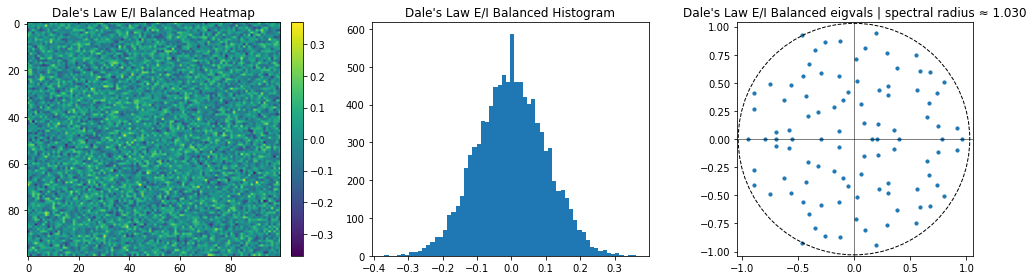

In [63]:
n = 100
target_var = xavier_variance(n, n, gain=1)
W = build_dale_ei(
    n,
    frac_exc=0.8,
    g=1.0,
    p=1.0,
    balanced=True,
    target_var=target_var,
    verbose=True,
    dtype=np.float32,
)
plot_weight_all(W, title="Dale's Law E/I Balanced")

In [64]:
def build_ring_cosine(
    n, a0=0.0, a1=1.0, a2=0.0, target_var=None, verbose=False, dtype=np.float32
):
    """
    Cosine kernel on a ring: supports a bump attractor for head-direction like models.
    """
    theta = 2 * np.pi * np.arange(n) / n
    d = theta[:, None] - theta[None, :]
    W = a0 + a1 * np.cos(d) + a2 * np.cos(2 * d)
    var_emp = float(((W - W.mean()) ** 2).mean())
    if verbose:
        print(f"Variance prior to scaling: {var_emp:.6f}")
    if target_var is not None and var_emp > 0:
        s = np.sqrt(target_var / var_emp)
        W = W * s
        if verbose:
            print(f"Variance after scaling:  {float(((W-W.mean())**2).mean()):.6f}")
    return W.astype(dtype)

Variance prior to scaling: 0.500000
Variance after scaling:  0.010000


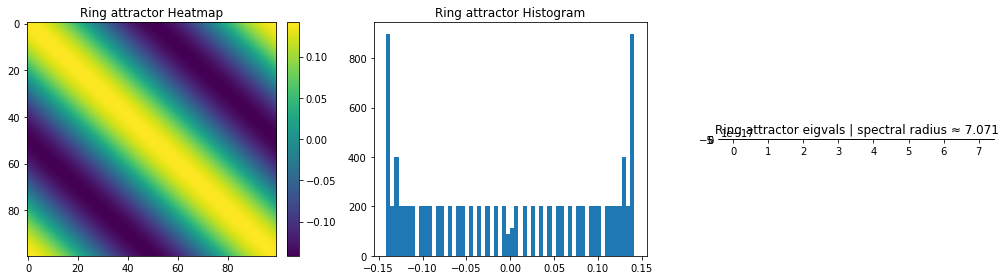

In [65]:
n = 100
target_var = xavier_variance(n, n, gain=1)
W = build_ring_cosine(
    n, a0=0.0, a1=1.0, a2=0.0, target_var=target_var, verbose=True, dtype=np.float32
)
plot_weight_all(W, title="Ring attractor")

In [66]:
def build_lowrank(
    n, rank=1, g=0.0, target_var=None, seed=None, verbose=False, dtype=np.float32
):
    """
    W = sum_{r=1..rank} m_r n_r^T / n  +  g/sqrt(n) * J  (J ~ N(0,1))
    """
    rng = np.random.default_rng(seed)
    M = rng.normal(0, 1.0, size=(n, rank))
    N = rng.normal(0, 1.0, size=(n, rank))
    W = (M @ N.T) / n
    if g != 0.0:
        J = rng.normal(0, 1.0, size=(n, n)) / np.sqrt(n)
        W = W + g * J
    np.fill_diagonal(W, 0.0)

    var_emp = float(((W - W.mean()) ** 2).mean())
    if verbose:
        print(f"Variance prior to scaling: {var_emp:.6f}")
    if target_var is not None and var_emp > 0:
        s = np.sqrt(target_var / var_emp)
        W = W * s
        if verbose:
            print(f"Variance after scaling:  {float(((W-W.mean())**2).mean()):.6f}")
    return W.astype(dtype)

Variance prior to scaling: 0.000082
Variance after scaling:  0.010000


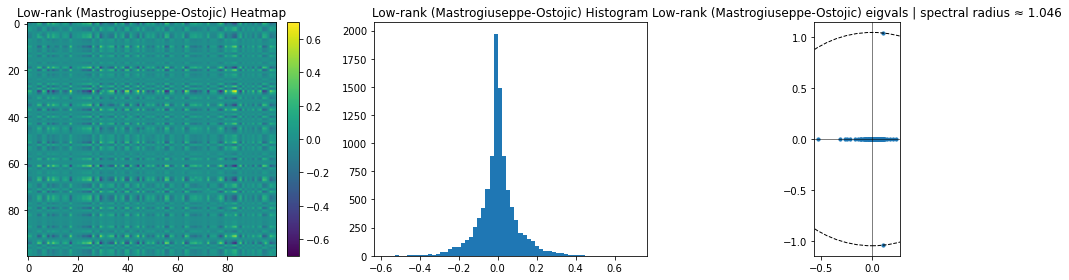

In [67]:
n = 100
target_var = xavier_variance(n, n, gain=1)
W = build_lowrank(
    n, rank=1, g=0.0, target_var=target_var, seed=None, verbose=True, dtype=np.float32
)
plot_weight_all(W, title="Low-rank (Mastrogiuseppe-Ostojic)")

In [68]:
def build_skew_rotation(
    n, alpha=0.0, target_var=None, seed=None, verbose=False, dtype=np.float32
):
    """
    W = S - alpha*I,  with S = G - G^T (skew-symmetric).
    Produces rotational/oscillatory dynamics; alpha>0 adds damping.
    """
    rng = np.random.default_rng(seed)
    G = rng.normal(0, 1.0, size=(n, n))
    S = G - G.T
    W = S - alpha * np.eye(n)

    var_emp = float(((W - W.mean()) ** 2).mean())
    if verbose:
        print(f"Variance prior to scaling: {var_emp:.6f}")
    if target_var is not None and var_emp > 0:
        s = np.sqrt(target_var / var_emp)
        W = W * s
        if verbose:
            print(f"Variance after scaling:  {float(((W-W.mean())**2).mean()):.6f}")
    return W.astype(dtype)

Variance prior to scaling: 2.036255
Variance after scaling:  0.010000


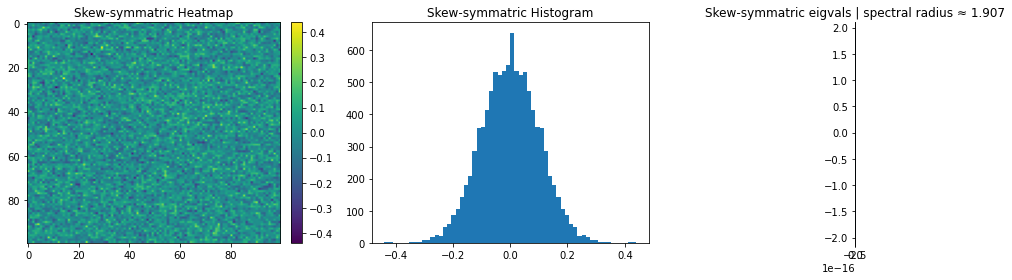

In [69]:
n = 100
target_var = xavier_variance(n, n, gain=1)
W = build_skew_rotation(
    n, alpha=0.0, target_var=target_var, seed=None, verbose=True, dtype=np.float32
)
plot_weight_all(W, title="Skew-symmatric")

In [75]:
def build_hopfield(
    patterns, alpha=0.0, target_var=None, verbose=False, dtype=np.float32
):
    """
    patterns: array (P, n) with entries in {-1, +1}.
    W = (patterns^T patterns)/n - alpha*I; diag cleared to 0.
    """
    P, n = patterns.shape
    W = (patterns.T @ patterns) / n
    np.fill_diagonal(W, 0.0)
    if alpha != 0.0:
        W = W - alpha * np.eye(n)

    var_emp = float(((W - W.mean()) ** 2).mean())
    if verbose:
        print(f"Variance prior to scaling: {var_emp:.6f}")
    if target_var is not None and var_emp > 0:
        s = np.sqrt(target_var / var_emp)
        W = W * s
        if verbose:
            print(f"Variance after scaling:  {float(((W-W.mean())**2).mean()):.6f}")
    return W.astype(dtype)


def make_random_patterns(P, n, seed=None):
    # random i.i.d
    rng = np.random.default_rng(seed)
    return rng.choice([-1, 1], size=(P, n)).astype(np.float32)


def zero_one_to_bipolar(X01):
    # X01: (P, n) with entries in {0,1}
    return (2.0 * X01 - 1.0).astype(np.float32)


# Example (one-hot labels)
def make_onehot_patterns(labels, n):
    X = np.zeros((len(labels), n), dtype=np.float32)
    X[np.arange(len(labels)), labels] = 1.0
    return X


def make_khot_bipolar(P, n, k, seed=None):
    rng = np.random.default_rng(seed)
    X = -np.ones((P, n), dtype=np.float32)
    for p in range(P):
        idx = rng.choice(n, size=k, replace=False)
        X[p, idx] = 1.0
    return X

Variance prior to scaling: 0.000293
Variance after scaling:  0.010000


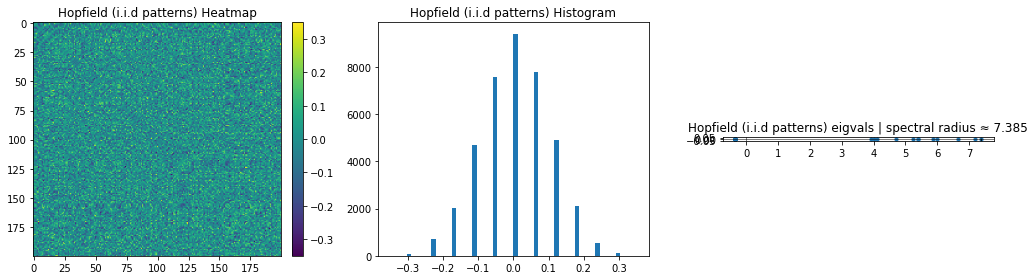

In [76]:
n = 100
target_var = xavier_variance(n, n, gain=1)
# Example
P, n = 12, 200
patterns = make_random_patterns(P, n, seed=0)
W = build_hopfield(patterns, alpha=0.0, target_var=target_var, verbose=True)
plot_weight_all(W, title="Hopfield (i.i.d patterns)")

Variance prior to scaling: 0.000045
Variance after scaling:  0.010000


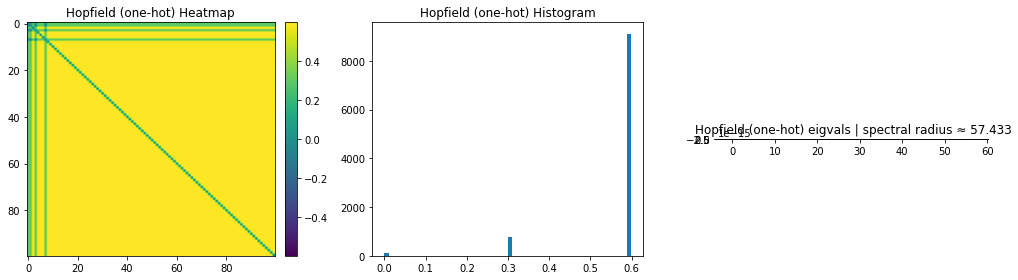

In [80]:
n = 100
target_var = xavier_variance(n, n, gain=1)
# Example
labels = [0, 3, 7, 1]
X01 = make_onehot_patterns(labels, n=100)
patterns = zero_one_to_bipolar(X01)
W = build_hopfield(patterns)
W = build_hopfield(patterns, alpha=0.0, target_var=target_var, verbose=True)
plot_weight_all(W, title="Hopfield (one-hot)")

Variance prior to scaling: 0.000600
Variance after scaling:  0.010000


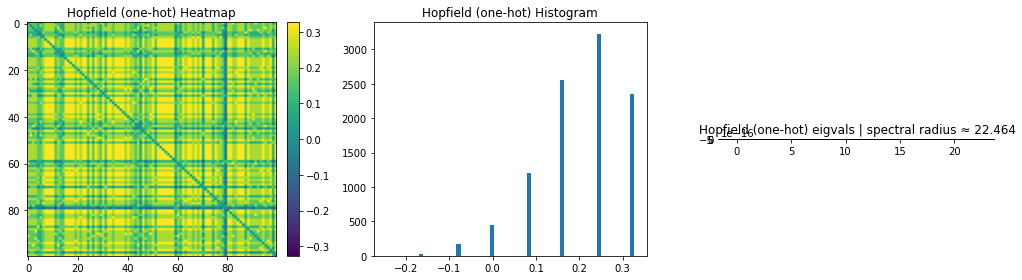

In [81]:
n = 100
target_var = xavier_variance(n, n, gain=1)
patterns = make_khot_bipolar(P=8, n=100, k=10, seed=1)
W = build_hopfield(patterns)
W = build_hopfield(patterns)
W = build_hopfield(patterns, alpha=0.0, target_var=target_var, verbose=True)
plot_weight_all(W, title="Hopfield (one-hot)")

In [71]:
def build_global_inhibition(
    n, w_self=1.0, w_inh=-1.0, target_var=None, verbose=False, dtype=np.float32
):
    """
    W = w_self*I + w_inh*(1 - I). All-to-all inhibition; promotes competition.
    """
    W = w_inh * np.ones((n, n), dtype=np.float32)
    np.fill_diagonal(W, w_self)
    var_emp = float(((W - W.mean()) ** 2).mean())
    if verbose:
        print(f"Variance prior to scaling: {var_emp:.6f}")
    if target_var is not None and var_emp > 0:
        s = np.sqrt(target_var / var_emp)
        W = W * s
        if verbose:
            print(f"Variance after scaling:  {float(((W-W.mean())**2).mean()):.6f}")
    return W.astype(dtype)

Variance prior to scaling: 0.039600
Variance after scaling:  0.010000


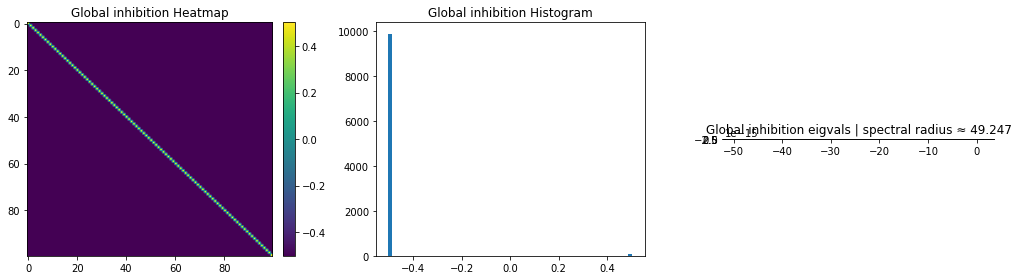

In [72]:
n = 100
target_var = xavier_variance(n, n, gain=1)
W = build_global_inhibition(
    n, w_self=1.0, w_inh=-1.0, target_var=target_var, verbose=True, dtype=np.float32
)
plot_weight_all(W, title="Global inhibition")